# Analisi Istogrammi di Carica Trigger

Import delle librerie necessarie

In [1]:
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.14/04


#### Disclaimer
Non sappiamo perchè ma i primi 1024 dati corrispondenti quindi al primo ipotetico evento sono dati di solo rumore, non andrebbero quindi considerati, tuttavia sono stati lasciati in quanto sottraendo il piedistallo il contributo di tale primo set all'istogramma di carica risulta trascurabile

#### Opzioni Acquisizione
Eseguendo il programma di acquisizione sono stati dati come parametri:
- Trigger su Channel 0 (coincidenze)
- Delay 400 
- Threshold -150 mV
- neg

## $\underline{dualCh.root}$
Di seguito l'analisi preliminare dei dati $.root$ ottenuti con il DRS per il PMT Blu e Verde insieme, l'obiettivo è costruire l'istogramma di carica, è stato inoltre eseguito un fit della distribuzione ottenuta con una Landau (usando Root) e graficando il tutto con python

Nel codice che segue sono stati estratti i dati dal $.root$ per graficare i singoli eventi in funzione del tempo in modo da avere la forma d'onda

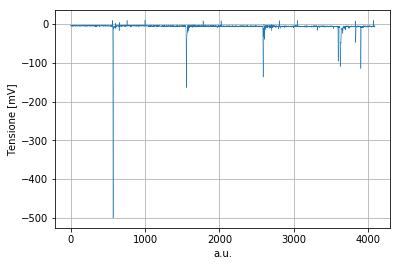

In [61]:
fileROOT = root.TFile('../../../Data/PMTgem/prova1G0_480.root' )
#_490_1000eventi.root')
# Trigger/dualCh.root')#"chargeDataBlu.root") #nome del rootfile
tree = fileROOT.Get("t1") #nome del datatree

nDat = 1024*4 #numero dati per evento
nEvts = tree.GetEntries() #numero di eventi
n = 1024
#creo due array vuoti per salvare wave_array e time_array del .root

wave = np.zeros((nEvts,nDat))
time = np.zeros((nEvts,nDat))

#eseguo un ciclo sul tree e salvo i dati dentro gli array come ulteriori array...
#quindi adesso avrò array 2d in cui il primo indice si riferisce all'evento e il secondo al dato 
#contenuto dentro quell'evento
i=0
for dat in tree:
    wave[i] = np.array(dat.wave_array)
    time[i] = np.array(dat.time_array)
    i = i+1

#wave = wave.reshape(1024000)

plt.plot(wave[7] , linewidth = .5)#stampo il 7mo evento escludendo l'evento 0 che è solo rumore
plt.xlabel('a.u.')
plt.ylabel('Tensione [mV]')
plt.grid()
plt.show()

I dati dei due canali vengono separati in due diversi array per un uso più intuitivo nell'analisi

In [62]:
#i primi 1024 sono del BLU

waveB = np.zeros((nEvts , nDat/4))
waveV= np.zeros((nEvts , nDat/4))

timeB= np.zeros((nEvts , nDat/4))
timeV= np.zeros((nEvts , nDat/4))

for i in range(nEvts):
    for j in range(nDat):
        if j >= nDat/4 and j < nDat/2:
            waveB[i][j-n] = wave[i][j]
            timeB[i][j-n] = time[i][j]
        elif j >= nDat/2 and j < nDat*3/4:
            waveV[i][j-2*n] = wave[i][j]
            timeV[i][j-2*n] = time[i][j]

Viene quindi stampato un grafico di controllo di una delle forme d'onda di un singolo evento di un solo PMT

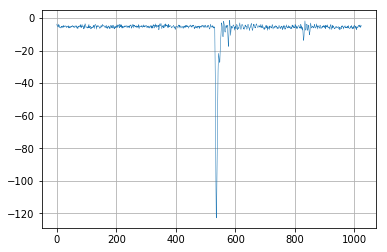

In [63]:
plt.plot(waveB[1] , linewidth = .5)
plt.grid()
plt.show()


Di seguito viene calcolata la tensione media di piedistallo e viene quindi sottratta a tutto il dataset in modo da poter fare l'integrale di carica senza curarsi della carica di piedistallo. Viene quindi graficato lo stesso evento precedente escludendo il piedistallo

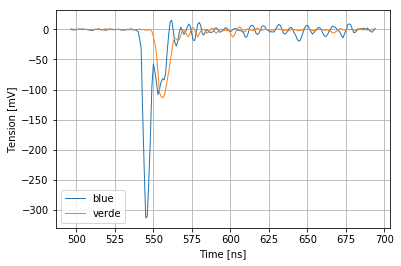

In [64]:
#creo un array per salvare i valori medi di tensione di piedistallo
meanPedestalB = np.zeros((nEvts,1))
meanPedestalV = np.zeros((nEvts,1))

#scorro i dati e per ciascun evento seleziono una zona pre-segnale di cui faccio la media
#riscrivo quindi i dati scalandoli della media di piedistallo
for i in range(nEvts):
    waveB[i] = waveB[i]-np.mean(waveB[i][100:200])
    waveV[i] = waveV[i]-np.mean(waveV[i][100:200])

#stampo la forma d'onda riscalata solo intorno al massimo
ee = 25
plt.plot(timeB[ee][500:700] , waveB[ee][500:700] , linewidth = 1 , label = "blue")
plt.plot(timeV[ee][500:700] , waveV[ee][500:700] , linewidth = 1 , label = 'verde')
plt.xlabel('Time [ns]')
plt.ylabel('Tension [mV]')
plt.legend()
plt.grid()
#plt.savefig('../Grafici/eventoPMT.png')
plt.show()

Degli eventi precedenti, opportunamente normalizzati alla resistenza $R = 50 \Omega$, è stato calcolato l'integrale (Carica depositata) di ciascun evento e salvato in un opportuno array.
Tali valori sono quindi stati rappresentati in un istogramma di carica e ne è stata calcolata la media.

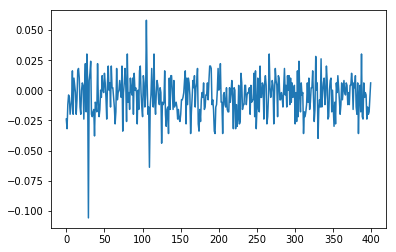

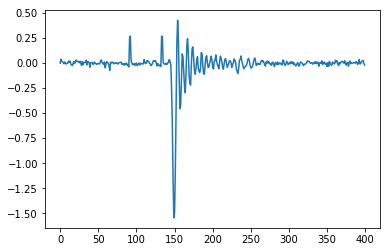

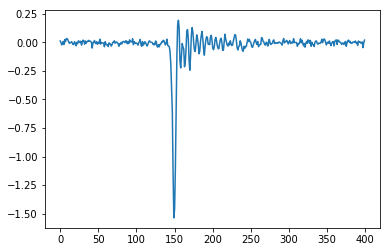

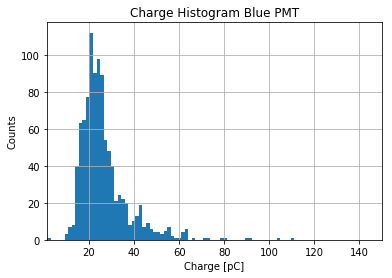

La carica Media depositata è (26.4707240129 +/- 11.0647296053) pC


In [65]:
#creo un array di 0 per salvare i dati di carica di ciascun evento
integralB = np.zeros(nEvts)
integralV = np.zeros(nEvts)

R = 50 #resistenza in Ohm
waveAB = waveB/R #conversione dati Tensione -> dati Corrente
waveAV = waveV/R

aminB = np.arange(nEvts)
aminV = np.arange(nEvts)

for i in range(nEvts):
    aminB[i] = int(waveB[i].argmin())
    aminV[i] = int(waveV[i].argmin())
    
#Eseguo l'Integrale solo in un intorno del massimo
for i in range(nEvts):
    integralB[i] = sum(-waveAB[i][ 400 : 800] ) 
    integralV[i] = sum(-waveAV[i][ 400: 800 ])
    if integralV[i] < 10:
        plt.plot(waveAV[i][400:800])
        plt.show()
    
#Istogramma di Carica    
plt.title('Charge Histogram Blue PMT')
plt.ylabel('Counts')
plt.xlabel('Charge [pC]')
yB , xB , _ = plt.hist(integralB , bins=70 , density = False) #salva x e y dell'hist nelle variabili esplicitate
#plt.hist(integralV , bins=70)
plt.grid()
#plt.xticks(np.arange(min(integralB),170, 15))
plt.xlim(min(integralB) , 150)
#plt.savefig('../Grafici/chargeHistBlu.png')
plt.show()

#calcolo la carica media depositata e la relativa sigma
QmediaB = np.mean(integralB)
sigmaQmediaB = np.std(integralB)

print("La carica Media depositata è ({0} +/- {1}) pC".format(QmediaB , sigmaQmediaB))



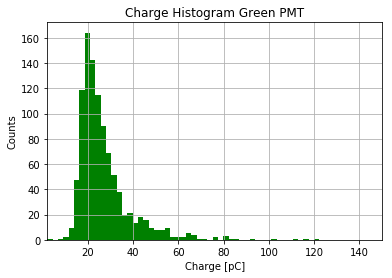

La carica Media depositata è (27.0423140143 +/- 13.1456187017) pC


In [66]:
yV , xV , _ = plt.hist(integralV , bins=70 , color = 'green')
plt.grid()
plt.xlim(min(integralV) , 150)
#plt.xticks(np.arange(min(integralV), 150, 15))
plt.title('Charge Histogram Green PMT')
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
#plt.savefig('../Grafici/chargeHistVerde.png')
plt.show()

QmediaV = np.mean(integralV)
sigmaQmediaV = np.std(integralV)

print("La carica Media depositata è ({0} +/- {1}) pC".format(QmediaV , sigmaQmediaV))


## Fit delle Distribuzioni
Di seguito sono stati eseguiti i fit delle distribuzioni di carica ottenute. Per farlo sono state usate le librerie di ROOT, vengono inoltre subito stampati i parametri di fit

In [8]:
from ROOT import TMath , TCanvas , TGraph , TF1

c = TCanvas()
gB = TGraph(xB.size, xB.astype(np.double),yB.astype(np.double))
#TF1 f1("f1","[0]*TMath::Landau(-x,[1],[2])",0,1);

#func=TF1("func","TMath::Landau(-x,[0],[1])")
#func=TF1("func","[0]*TMath::Exp(-[1]*((x+TMath::Exp(-x))/2))")

fit = gB.Fit("landau")


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      55799.2
NDf                       =           68
Edm                       =  9.53345e-10
NCalls                    =          118
Constant                  =      7298.79   +/-   97.5186     
MPV                       =      22.6038   +/-   0.119958    
Sigma                     =      4.63131   +/-   0.0809245    	 (limited)


Viene quindi stampato il grafico usando python, qui il passaggio è un pò un magheggio, ma funziona. Sostanzialmente usiamo la libreria $scipy.stats$ che al suo interno ha la funzione $moyal$ che non è altro che un'approssimazione della Landau. Questa la usiamo per fare un ulteriore fit (che è compatibile con quello di ROOT) e che ci permette facilmente di usare i dati di fit per fare un grafico.

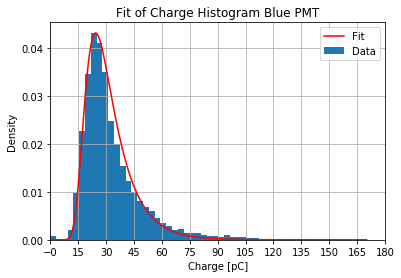

In [9]:
from scipy import stats as st
from scipy.stats import moyal

mean, var, skew, kurt = st.moyal.stats(moments='mvsk')

mB ,sB  = st.moyal.fit(integralB)
rv = moyal()
x1B = np.linspace(min(integralB), 170, len(integralB))

#i parametri qui sono le x da graficare, 
#local (cioè dove spostare il grafico rispetto all'origine) 
#e lo scale, cioè di quanto dilatare il grafico affinchè risulti 
#più simile alla distribuzione interessata

#la cosa importante da notare è che l'unico dei parametri rilevanti al fine 
#della correttezza statistica del fit è il local, infatti lo scale non fa altro che dilatare
#la curva di fit in verticale, ma essendo il fit di un istogramma quello porta informazioni solo
#sulla frequenza specifica, ma non sul valore più probabile o sul valore medio in quanto non influenza
#singolarmente pochi dati ma tutti i dati contemporaneamente

pdfB = st.moyal.pdf(x1B , mB ,sB-1.5) #quindi lo scale è stato aggiustato a mano per bellezza grafica

plt.plot(x1B, pdfB, 'r-', label='Fit')
y1B, x1B , _ = plt.hist(integralB , density = True , bins=70 , label = 'Data')
plt.grid()
plt.title('Fit of Charge Histogram Blue PMT')
plt.xlabel('Charge [pC]')
plt.ylabel('Density')
plt.legend()
plt.xlim(min(x1B) , 180)
plt.xticks(np.arange(min(integralB),180, 15))
#plt.savefig('../Grafici/FitBlu.png')
plt.show()

#print(s-1.5 , max(y) , max(y1) , max(y)/max(y1) , len(pdf) , x1.shape, len(integralB))
#print("MPV = " , x1[pdf.argmax()])

Sono stati eseguiti gli stessi conti anche per l'altra distribuzione

In [10]:
from ROOT import TMath , TCanvas , TGraph , TF1

c = TCanvas()
gV = TGraph(xV.size, xV.astype(np.double),yV.astype(np.double))
fit = gV.Fit("landau")


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      52890.5
NDf                       =           68
Edm                       =  3.29223e-07
NCalls                    =          113
Constant                  =      11525.6   +/-   118.067     
MPV                       =      20.0422   +/-   0.0768505   
Sigma                     =      3.79237   +/-   0.0505165    	 (limited)


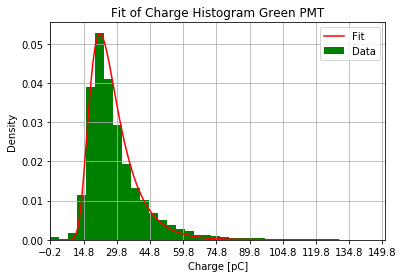

In [11]:
from scipy import stats as st
from scipy.stats import moyal

mean, var, skew, kurt = st.moyal.stats(moments='mvsk')

mV ,sV  = st.moyal.fit(integralV)
#rv = moyal()
x1V = np.linspace(min(integralV), 130, len(integralV))

pdfV = st.moyal.pdf(x1V , mV ,sV-1.5)

plt.plot(x1V, pdfV, 'r-', label='Fit')
y1V, x1V , _ = plt.hist(integralV , density = True , bins=70 , color = 'green' , label = 'Data')
plt.grid()
plt.title('Fit of Charge Histogram Green PMT')
plt.xlabel('Charge [pC]')
plt.ylabel('Density')
plt.legend()
plt.xlim(min(x1V) , 151)
plt.xticks(np.arange(min(integralV),151, 15))
#plt.savefig('../Grafici/FitVerde.png')
plt.show()



In conclusione sono stati ottenuti i seguenti parametri:
- PMT Blu:
 * $MPV_{Blu}$ = $(22.60\pm 0.12)$ $pC$
 * $\sigma_{Blu} = (4.63\pm 0.08)$ $pC$
- PMT Verde:
 * $MPV_{Verde}$ = $(20.04\pm 0.08)$ $pC$        
 * $\sigma_{Verde} = (3.79\pm 0.05)$ $pC$

## Confronto Istogrammi di Carica

Di seguito riportiamo i due istogrammi di carica affiancati e le relative cariche medie depositate

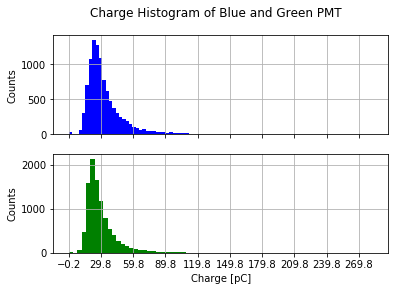

In [12]:
f , (ax1,ax2) = plt.subplots(2, 1, sharey=False , sharex = True)

f.suptitle('Charge Histogram of Blue and Green PMT')
#f.subpylabel('Counts')
ax1.set(ylabel = 'Counts')
ax1.hist(integralB , bins=70 , color='blue')
#ax1.set_xticks(np.arange(min(integralB),max(integralB)+1 , 100))
ax1.grid()

ax2.set(ylabel = 'Counts' , xlabel = 'Charge [pC]')
ax2.hist(integralV, bins=70 , color='green')
ax2.grid()
ax2.set_xticks(np.arange(min(integralV),max(integralV)+5 , 30))

plt.show()


Stimando la carica media depositata nei due casi dagli istogrammi, con la relativa incertezza data dalla deviazione standard, si ottiene:
- $\bar{Q}_{Blu}$ $= (36.998 \pm 16.588)$ $pC$
- $\bar{Q}_{Verde}$ $= (38.590 \pm 16.463)$ $pC$

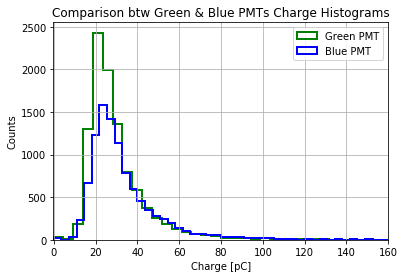

In [13]:
plt.hist(integralV , bins = 60, color = 'green' , label = 'Green PMT' , histtype = 'step' , fill = False , lw=2)
plt.hist(integralB , bins = 60 , color = 'blue' , label = 'Blue PMT', histtype = 'step' , fill = False , lw=2)
plt.xlim(-.2,160)
plt.legend()
plt.grid()
plt.title('Comparison btw Green & Blue PMTs Charge Histograms')
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
#plt.savefig('../Grafici/confrontoChargeHists.png')
plt.show()